# Voorspellen duur energie-neutraal huishouden

Eindopdracht data engineer opleiding [Bit-Academy](https://nlleertdoor.bit-academy.nl/). &copy; Paul Schouten 2022 

Deze file is een kopie van de [eindopdracht](Eindopdracht.ipynb), waarbij alleen het inladen van de dataset, het modelleren met XGBoost en het voorspellen van de energieopbrengst overgehouden zijn. Met deze file kan snel de voorspelling en opbrengst bijgewerkt worden.


In [1]:
import sqlite3
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns

# Database inlezen
conn = sqlite3.connect("database.db")
dataset = pd.read_sql('SELECT * FROM dataset', conn)
conn.close()

# Voor de zekerheid NaN weglaten (mochten ze er zijn)
dataset.dropna(axis=0, inplace=True)


## Modelleren

### XGBoost

[XGBoost](https://xgboost.readthedocs.io/en/stable/) is een machine learn systeem gebaseerd op decision trees. Bij dit type modellen worden de gegevens gesplitst. Iedere split zorgt ervoor dat de kwaliteit van de gesplitste data toeneemt, dus dat het steeds duidelijker wordt in welke catagorie de gegevens thuis horen. XGBoost doet dit op een slimme, maar vooral snelle manier volgens de documentatie. In onderstaand codeblok worden de geoptimaliseerde parameters voor het model gebruikt.


In [2]:
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from math import sqrt

# Opsplitsen datum/tijd naar jaar-maand-dag-uur
dataset['timestamp'] = pd.to_datetime(dataset["Time"])
dataset.set_index("timestamp", inplace=True)

dataset['dayofyear'] = dataset.index.dayofyear
dataset['year'] = dataset.index.year
dataset['quarter'] = dataset.index.quarter
dataset['month'] = dataset.index.month
dataset['day'] = dataset.index.day
dataset['hour'] = dataset.index.hour

# Opsplitsen dataset
X = dataset[["dayofyear", "year", "quarter", "month", "day", "hour", "temperatuur", "bewolking", "solar_altitude", "solar_azimuth"]]
y = dataset[["energy"]]

# split into train and test set
# Note: this is on a NON standardized dataset
X_train, X_test, y_train, y_test = train_test_split(X, y)

# Learning API uses a dmatrix
dmatrix = xgb.DMatrix(data=X_train, label=y_train)

# Parameters for training model
params = {'objective':'reg:squarederror',
         'eta': 0.05,
         'gamma': 1,
         'max_depth': 10,
         'lambda': 5,
         'alpha': 0,
         'min_child_weight': 1}

# Train model with parameters and
# look at 'rmse' (minimize)
# maximum 10000 rounds
# stop when result does not improve in 3 subsequent iterations
trained_model = xgb.train(params=params,
                          dtrain=dmatrix,
                          evals=[(dmatrix, 'rmse')],
                          verbose_eval=1000,
                          num_boost_round=10000,
                          early_stopping_rounds=3)

print(f'Num rounds: {trained_model.num_boosted_rounds()}')

# Check prediction for train set
print('\nTrain set:')
pred_train = trained_model.predict(xgb.DMatrix(data=X_train))

score = r2_score(y_train, pred_train)
print(f'r²: {score:.2f}')
print(f'RMSE train set: {sqrt(mean_squared_error(y_train, pred_train)):.2f}')

# Check prediction for test set
print('\nTest set:')
pred_test = trained_model.predict(xgb.DMatrix(data=X_test))

score = r2_score(y_test, pred_test)
print(f'r²: {score:.2f}')
print(f'RMSE test: {sqrt(mean_squared_error(y_test, pred_test)):.2f}') 


/home/paulschouten/Documents/bit-academy/data-engineer-eindopdracht/venv/lib64/python3.10/site-packages/xgboost/compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
/home/paulschouten/Documents/bit-academy/data-engineer-eindopdracht/venv/lib64/python3.10/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[0]	rmse-rmse:1041.98499
[1000]	rmse-rmse:59.84144
[2000]	rmse-rmse:21.66141
[3000]	rmse-rmse:8.49473
[4000]	rmse-rmse:3.64288
[5000]	rmse-rmse:1.86897
[5065]	rmse-rmse:1.79103
Num rounds: 5067

Train set:
r²: 1.00
RMSE train set: 1.79

Test set:


/home/paulschouten/Documents/bit-academy/data-engineer-eindopdracht/venv/lib64/python3.10/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


r²: 0.89
RMSE test: 333.24


## Batterij duur

Om te bepalen hoe lang de batterij mee gaat, wordt het principe `in - uit + productie = accumulatie` toegepast, vanuit het oogpunt van de batterij en de zonnepanelen. De hoeveelheid `in` is dan nul, aangenomen wordt dat de batterij niet opgeladen wordt via het net. Het energieverbruik is `uit` en wordt als constant door de dag heen beschouwd: 3500 kWh/jaar / 365 dagen/jaar / 24 uren/dag = 0.4 kWh per uur. De `productie` is de energie van de zonnepanelen. Als laatste blijft dan de `accumulatie` over, het opladen (of als deze negatief is het ontladen) van de batterij. Er wordt voor de voorspelling gestart met een volle batterij. Het XGBoost model wordt gebruikt in de voorspelling, omdat deze een meer reëel beeld geeft van de voorspelde energieproductie ten opzichte van het kNN model.


/home/paulschouten/Documents/bit-academy/data-engineer-eindopdracht/venv/lib64/python3.10/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


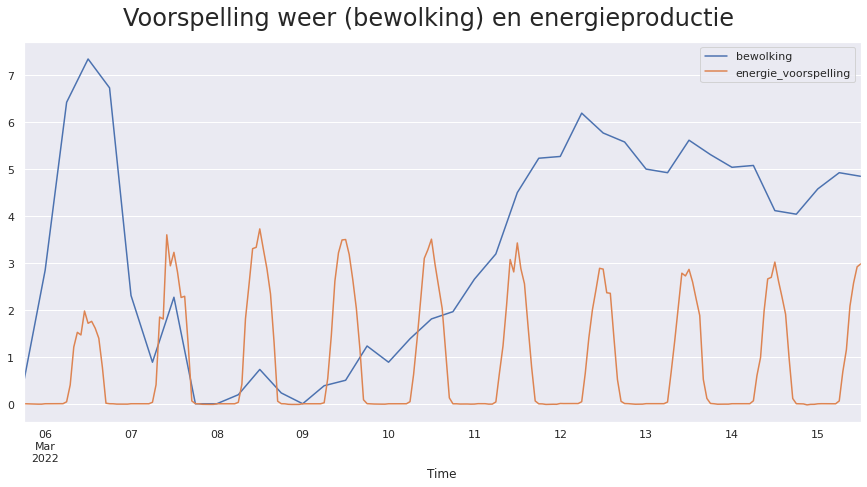

In [3]:
import pysolar

# Database inlezen
conn = sqlite3.connect("database.db")
voorspelling = pd.read_sql('SELECT * FROM knmi_forecast', conn)
conn.close()

# Tijd omzetten naar DateTime
# Toch jammer dat dit niet standaard gebeurd... (SQLite3 beperking als ik het goed heb...)
voorspelling["Time"] = pd.to_datetime(voorspelling["Tijdstip"])
voorspelling.drop(columns=["Tijdstip"], inplace=True)
voorspelling.set_index("Time", inplace=True)

voorspelling['dayofyear'] = voorspelling.index.dayofyear
voorspelling['year'] = voorspelling.index.year
voorspelling['quarter'] = voorspelling.index.quarter
voorspelling['month'] = voorspelling.index.month
voorspelling['day'] = voorspelling.index.day
voorspelling['hour'] = voorspelling.index.hour


# KNMI geeft per 6 uur voorspelling, interpoleren naar per uur
voorspelling = voorspelling.resample("1H").interpolate(method="linear")

# Info stand zon toevoegen
voorspelling["solar_altitude"] = pysolar.solar.get_altitude_fast(51.2, 6, voorspelling.index)
voorspelling["solar_azimuth"] = pysolar.solar.get_azimuth_fast(51.2, 6, voorspelling.index)

# Voorspelling energie berekenen:
# - Selecteren
# - Transformeren (standardscaler)
# - Prognosticeren (rijmt lekker)
X = voorspelling[['dayofyear', 'year', 'quarter', 'month', 'day', 'hour', "temperatuur", "bewolking", "solar_altitude", "solar_azimuth"]]

# Energie per kWh, niet per Wh
voorspelling["energie_voorspelling"] = trained_model.predict(xgb.DMatrix(data=X)) / 1000

# Verwachting voor de komende dagen laten zien
sns.set_theme()

fig, ax = plt.subplots(figsize=(15, 7))
g = voorspelling[["bewolking", "energie_voorspelling"]].plot(ax=ax)
fig.suptitle('Voorspelling weer (bewolking) en energieproductie', y=.95, fontsize=24)
plt.show()

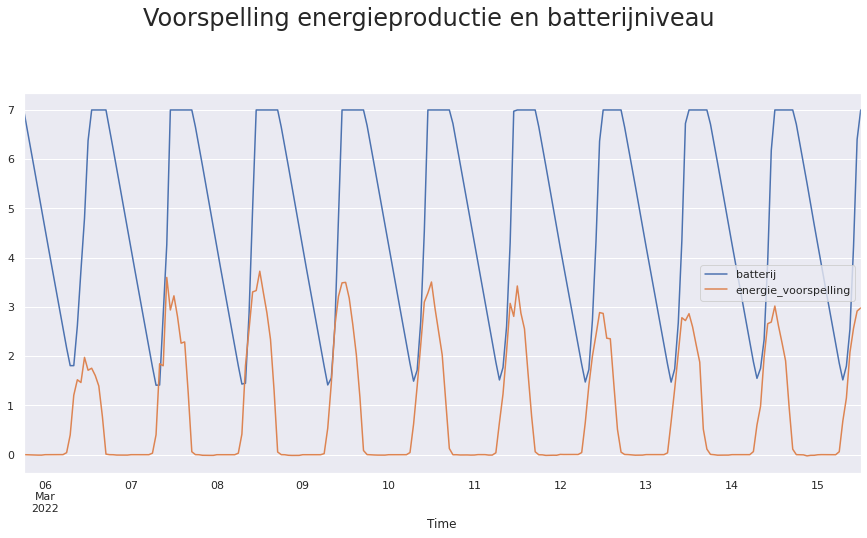

De batterij gaat de gehele periode mee


In [4]:
import math
# Nieuwe kolom aanmaken voor het niveau van de batterij,
# beginnen met een volle (7 kWh)
voorspelling["batterij"] = 0
bat_kolom = voorspelling.columns.get_loc("batterij")
voorspelling.iat[0, bat_kolom] = 7

energie_kolom = voorspelling.columns.get_loc("energie_voorspelling")

# Loop over alle rijen van het DataFrame. Op deze manier is de 
# vorige rij gemakkelijk te benaderen. Daarnaast kan het min/max
# niveau van de batterij gevolgd worden. _batterij_leeg_ wordt als
# "flag" gebruikt, om aan te geven dat de batterij leeg is.
batterij_leeg = False
for i in range(1, len(voorspelling)):
    # Opzoeken getallen om mee te rekenen
    productie = voorspelling.iloc[i-1, energie_kolom]
    accumulatie = 0 - 0.4 + productie
    bat_vorig = voorspelling.iloc[i-1, bat_kolom]
    
    # Nieuw batterijniveau berekenen, deze is:
    # - maximaal (min in deze functie) 7 kWh
    # - minimaal (max in deze functie) 0 kWh
    bat_huidig = max(min(7, bat_vorig + accumulatie), 0)
    if bat_huidig == 0 or batterij_leeg:
        batterij_leeg = True
        bat_huidig = math.nan
    
    voorspelling.iat[i, bat_kolom] = bat_huidig

# Grafiek tekenen
fig, ax = plt.subplots(figsize=(15, 7))
voorspelling[["batterij", "energie_voorspelling"]].plot(ax=ax)
fig.suptitle('Voorspelling energieproductie en batterijniveau', y=1.05, fontsize=24)
plt.show()

if batterij_leeg: 
    print(f'De batterij is leeg op: {max(voorspelling.dropna().index)}')
else:
    print('De batterij gaat de gehele periode mee')

## Model evaluatie

Om het model te evalueren is onderstaande grafiek gemaakt. Deze laat in de tijd zien welke energie productie er voorspeld is versus de actuele opbrengst van de zonnepanelen. Bij herhaalde simulaties zal er ook een onzekerheid getekend worden. In verband met het verversen van de weersvoorspelling door het KNMI wordt er maar één keer per dag de simulatie opgeslagen in de database.

Ophalen evaluation OK
Getting solaredge data from 2022-02-09 06:00:00


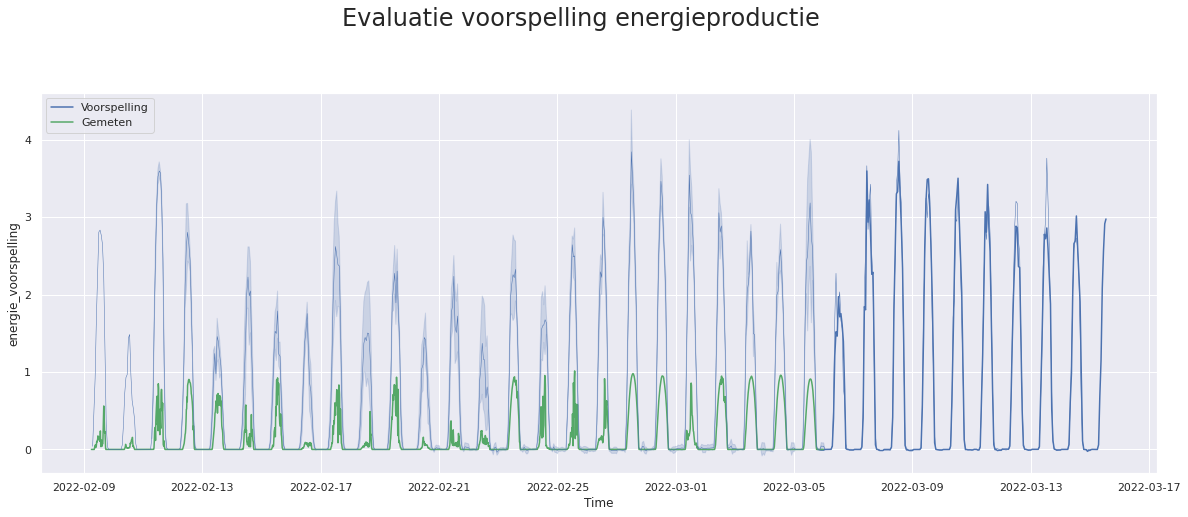

Voorspelling voor vandaag opslaan


In [5]:
# 1. Vanaf wanneer tekenen?
# Model evaluatie tekenen vanaf eerste run,
# Dit is de eerste datum in "evaluation" of anders
# de eerste datum van "voorspelling"
conn = sqlite3.connect("database.db")
cursor = conn.cursor()

# Datum opvragen in try...             except... 
#                   (tabel bestaat)... (eerste run)...
try:
    sql = 'SELECT * FROM knn_evaluation'
    previous_runs = pd.read_sql(sql, conn)
    previous_runs["Time"] = pd.to_datetime(previous_runs["Time"])
    first_date = previous_runs["Time"].min()
    print("Ophalen evaluation OK")
    
except (sqlite3.Error, pd.io.sql.DatabaseError) as e:
    print(f'Foutmelding database: {e}')
    first_date = voorspelling.index.min()
    previous_runs = None
    
print(f'Getting solaredge data from {first_date}')


# 2. Data ophalen uit database solaredge
sql = f'SELECT * FROM solaredge_history WHERE DATETIME(tijdstip) >= DATETIME("{first_date}")'
solaredge = pd.read_sql(sql, conn)

# Tijd omzetten naar datetime
solaredge["Time"] = pd.to_datetime(solaredge["tijdstip"])
solaredge.set_index("Time", inplace=True)
solaredge.drop("tijdstip", axis=1, inplace=True)

# Tijdzone info toevoegen, SolarEdge is in de "local" time
solaredge = solaredge.tz_localize("Europe/Amsterdam", ambiguous="NaT", nonexistent="NaT")

# Energie van Wh naar kWh
solaredge["energy"] = solaredge["energy"] / 1000.0

# Grafiek opbouwen
fig, ax = plt.subplots(figsize=(20, 7))
sns.lineplot(data=voorspelling, x="Time", y="energie_voorspelling", color='b', ax=ax)
sns.lineplot(data=solaredge, x="Time", y="energy", color='g', ax=ax)
if previous_runs is not None: 
    sns.lineplot(data=previous_runs, x="Time", y="energie_voorspelling", color='b', linewidth=0.5, ax=ax)
plt.legend(labels=["Voorspelling", "Gemeten"], loc="upper left")
fig.suptitle('Evaluatie voorspelling energieproductie', y=1.05, fontsize=24)
plt.show()

# 3. Huidige voorspelling opslaan (alleen voor vandaag)
# Tabel aanmaken indien nog niet aanwezig
sql = """CREATE TABLE IF NOT EXISTS knn_evaluation_days ( 
            datum DATETIME PRIMARY KEY NOT NULL );
      """
conn.execute(sql)

# Datum van vandaag ophalen uit tabel
sql = f"SELECT datum FROM knn_evaluation_days WHERE datum = DATE('now')"
cursor.execute(sql)
result = cursor.fetchall()

if len(result) == 0:
    # Day not found, save voorspelling
    print("Voorspelling voor vandaag opslaan")
    exporteren = voorspelling[["temperatuur", "neerslag", "bewolking", "solar_altitude", "solar_azimuth", "energie_voorspelling", "batterij"]]
    exporteren.to_sql("knn_evaluation", conn, if_exists="append")
    
    sql = f"INSERT INTO knn_evaluation_days VALUES ( DATE('now') )"
    cursor.execute(sql)
else:
    print("Voorspelling voor vandaag is al opgeslagen")
    
conn.commit()
conn.close()